# Remote data access to the GHCNd database stored as a Discrete Sampling Geometry

In this notebook we get station data for stations located in the city of Santander (Cantabria, Spain). We will access the data in a remote data access fashion and compute extreme values for the stations.

In [1]:
import fsspec
import h5py

import cftime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Circle, Rectangle
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import cartopy
import cartopy.crs as ccrs

Since netCDF does not provide the tools to access the data remotely in an efficient manner, we will access the data using native HDF5 capabilities.

In [2]:
fs = fsspec.open("https://zenodo.org/records/15124414/files/ghcn-dsg.nc", cache_type="first", block_size=2**20)
f = h5py.File(fs.open(), page_buf_size=64*2**20)

In [3]:
dict(f["tasmin"].attrs)

{'_Netcdf4Coordinates': array([2], dtype=int32),
 '_FillValue': array([9999], dtype=int16),
 'missing_value': array([9999], dtype=int16),
 'standard_name': b'air_temperature',
 'coordinates': b'time lat lon alt station',
 'units': b'Celsius',
 'scale_factor': array([0.1]),
 'DIMENSION_LIST': array([array([<HDF5 object reference>], dtype=object)], dtype=object)}

In [4]:
dict(f["pr"].attrs)

{'_Netcdf4Coordinates': array([2], dtype=int32),
 '_FillValue': array([9999], dtype=int16),
 'missing_value': array([9999], dtype=int16),
 'standard_name': b'precipitation_flux',
 'coordinates': b'time lat lon alt station',
 'units': b'mm',
 'scale_factor': array([0.1]),
 'DIMENSION_LIST': array([array([<HDF5 object reference>], dtype=object)], dtype=object)}

Locate the stations of interest and load the data for maximum and minimum temperatures.

In [5]:
names = np.array(["SPE00119972", "SPE00119990", "SPE00119981"], dtype=str)
stations = [i
            for i, st in enumerate(f["station"][...].view("S11").astype(str).ravel())
            if st in names]
names = [st.decode("ascii") for st in f["station"][...].view("S11")[stations].ravel()]

lats = f["lat"][stations]
lons = f["lon"][stations]

# Needed to locate the data for the stations of interest
rowSize = f["rowSize"][...]
rowStart = np.insert(rowSize.cumsum(), 0, 0)[:-1]
fidx = np.array([rowStart, rowSize.cumsum()]).T
idx = fidx[stations]

# Load temperature data for the subset of stations
size = (idx[:,1] - idx[:,0]).sum()
st = []
time = np.empty(shape=(size,))
tasmax = np.empty(shape=(size,))
tasmin = np.empty(shape=(size,))
pr = np.empty(shape=(size,))
frm = 0
for i in range(len(names)):
    to = frm + (idx[i,1] - idx[i,0])
    st.extend([names[i]]*(to-frm))
    time[frm:to] = f["time"][fidx[stations[i],0]:fidx[stations[i],1]]
    tasmax[frm:to] = f["tasmax"][fidx[stations[i],0]:fidx[stations[i],1]]
    tasmin[frm:to] = f["tasmin"][fidx[stations[i],0]:fidx[stations[i],1]]
    pr[frm:to] = f["pr"][fidx[stations[i],0]:fidx[stations[i],1]]

    frm = to

Plot the locations of the stations.

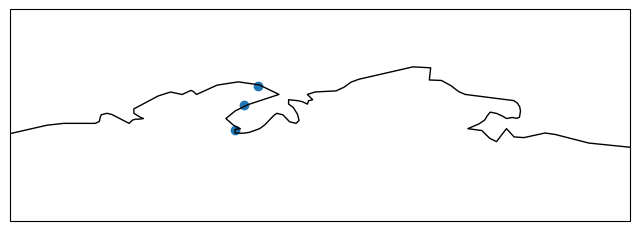

In [6]:
fig=plt.figure(figsize=(8,6))

ax=fig.add_subplot(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-4.15, -3.2721, 43.3, 43.6], crs=ccrs.PlateCarree())
ax.scatter(lons, lats)

# Santander stations

Create a Pandas DataFrame that will ease data analysis.

In [7]:
df = pd.DataFrame.from_dict({
    "station": st, 
    "time": pd.to_datetime(cftime.num2pydate(
        time,
        f["time"].attrs["units"].decode("ascii"),
        f["time"].attrs["calendar"].decode("ascii"))),
    "pr": pr / 10,
    "tasmax": tasmax / 10,
    "tasmin": tasmin / 10}).replace(999.9, None)

df["year"] = df["time"].dt.to_period("Y")
df = df[df["year"] < "2025"]
df["month"] = df["time"].dt.month

/tmp/ipykernel_871365/1341366059.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  data = df[df["station"] == names[j]].set_index("time")[["tasmax", "tasmin"]].resample("Y").mean()
/tmp/ipykernel_871365/1341366059.py:17: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  data = df[df["station"] == names[j]].set_index("time")[["pr"]].resample("Y").sum()
/tmp/ipykernel_871365/1341366059.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  data = df[df["station"] == names[j]].set_index("time")[["tasmax", "tasmin"]].resample("Y").mean()
/tmp/ipykernel_871365/1341366059.py:17: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  data = df[df["station"] == names[j]].set_index("time")[["pr"]].resample("Y").sum()
/tmp/ipykernel_871365/1341366059.py:10: FutureWarning: 'Y' is deprecated a

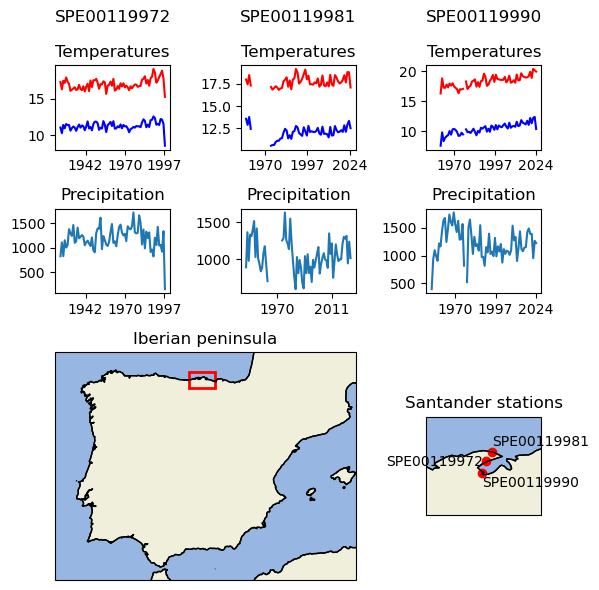

In [8]:
fig = plt.figure(figsize=(6, 6))
g = GridSpec(4,3, figure=fig)

tas1, pr1 = plt.subplot(g[0,0], title=f"{names[0]}\n\nTemperatures"), plt.subplot(g[1,0], title="Precipitation")
tas2, pr2 = plt.subplot(g[0,1], title=f"{names[1]}\n\nTemperatures"), plt.subplot(g[1,1], title="Precipitation")
tas3, pr3 = plt.subplot(g[0,2], title=f"{names[2]}\n\nTemperatures"), plt.subplot(g[1,2], title="Precipitation")

date_fmt = mdates.DateFormatter('%Y')
for j in range(3):
    data = df[df["station"] == names[j]].set_index("time")[["tasmax", "tasmin"]].resample("Y").mean()
    ax = fig.axes[j*2]
    ax.plot(data.index, data["tasmin"], c="blue")
    ax.plot(data.index, data["tasmax"], c="red")
    ax.xaxis.set_major_formatter(date_fmt)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(3))

    data = df[df["station"] == names[j]].set_index("time")[["pr"]].resample("Y").sum()
    ax = fig.axes[j*2+1]
    ax.plot(data.index, data["pr"].replace(0, None))
    ax.xaxis.set_major_formatter(date_fmt)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(3))

spain = plt.subplot(g[2:,:2], aspect="auto", title="Iberian peninsula", projection=ccrs.PlateCarree())
spain.coastlines()
spain.set_extent([-10.5, 3.5, 35.5, 44.5])
cantabria = plt.subplot(g[2:, 2:], title="Santander stations", projection=ccrs.PlateCarree())
cantabria.coastlines()
cantabria_bbox = [-4., -3.65, 43.3, 43.6]
cantabria.set_extent(cantabria_bbox)
#spain.add_patch(Circle((-3.8, 43.18), .6, fill=False, color="red", linewidth=2))
spain.add_patch(Rectangle((-4.27, 43.1), 1.2, .6, fill=False, color="red", linewidth=2))
spain.add_feature(cartopy.feature.OCEAN, zorder=0)
spain.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
cantabria.add_feature(cartopy.feature.OCEAN, zorder=0)
cantabria.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

cantabria.scatter(lons, lats, c="red")
cantabria.text(lons[0]-.01, lats[0]-.001, names[0], va="center", ha="right")
cantabria.text(lons[1], lats[1]+.01, names[1], va="bottom")
cantabria.text(lons[2], lats[2]-.01, names[2], va="top")

plt.tight_layout()
plt.savefig("santander.png")

# Extremes for Spain

Check the time periods for which the stations provide temperature data.

In [9]:
df.dropna(how="all", subset=["tasmin", "tasmax"])[["station", "time"]].groupby("station").agg(["min", "max"])

time           
                   min        max
station                          
SPE00119972 1924-01-01 1997-04-07
SPE00119981 1957-02-01 2024-12-31
SPE00119990 1954-01-01 2024-12-31

https://x-y.es/clima/cantabria/1111X-santander

Plot the evolution of temperature for each station, averaged by year to remove seasonality.

In [10]:
year_mean = df[["station", "year", "tasmax", "tasmin"]].groupby(["station", "year"]).mean()

Get the extreme values for the station *SPE00119981*.

In [11]:
SPE00119981 = df[df["station"] == "SPE00119981"]
tmx = SPE00119981[["month", "tasmax"]].groupby("month").max().reset_index()
tmn = SPE00119981[["month", "tasmin"]].groupby("month").min().reset_index()

extremes = pd.concat([
    SPE00119981[["tasmax", "year", "month"]].merge(
        tmx, how="inner", on=["tasmax", "month"]).rename(
        {"month": "tmax_month", "year": "tmax_year"}, axis=1).groupby(
        ["tasmax", "tmax_month"]).first().reset_index(),
    SPE00119981[["tasmin", "year", "month"]].merge(
        tmn, how="inner", on=["tasmin", "month"]).rename(
        {"month": "tmin_month", "year": "tmin_year"}, axis=1).groupby(
        ["tasmin", "tmin_month"]).first().reset_index()
    ],
    axis=1)

In [12]:
extremes

,tasmax,tmax_month,tmax_year,tasmin,tmin_month,tmin_year
0,23.8,1,2016,-5.4,3,1984
1,23.8,12,2012,-1.8,1,1985
2,26.6,2,1990,-0.8,2,2018
3,28.6,4,1987,0.0,4,1973
4,28.6,11,2015,0.0,12,1974
5,28.7,3,2021,1.4,11,1999
6,32.4,10,1983,4.5,10,2018
7,33.6,5,2020,5.3,5,1982
8,35.5,7,1990,8.0,9,1978
9,36.6,6,1994,9.0,6,1978


# Station coverage

In [13]:
stations = f["station"][...].view("S11").astype(str).ravel()
mask = (np.char.startswith(stations, "AR0") |
        np.char.startswith(stations, "CI") |
        np.char.startswith(stations, "BR") |
        np.char.startswith(stations, "PA"))
subset = stations[mask]

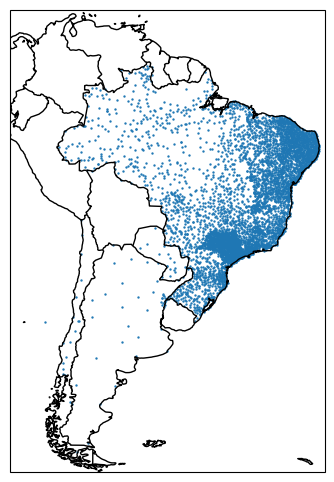

In [14]:
fig=plt.figure(figsize=(8,6))

ax=fig.add_subplot(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-81, -34, -56, 13], crs=ccrs.PlateCarree())
ax.scatter(f["lon"][mask], f["lat"][mask], s=.5)
ax.add_feature(cartopy.feature.BORDERS)

In [15]:
(np.char.startswith(stations, "AR0").sum(),
 np.char.startswith(stations, "CI").sum(),
 np.char.startswith(stations, "BR").sum(),
 np.char.startswith(stations, "PA").sum())

(40, 21, 5989, 24)

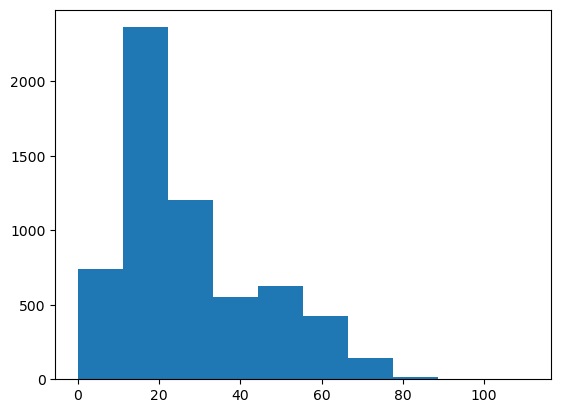

In [16]:
fig, ax = plt.subplots()

h = ax.hist(rowSize[mask] // 360)